Running Fixed window...
Running Variable window...
Running Weighted window...


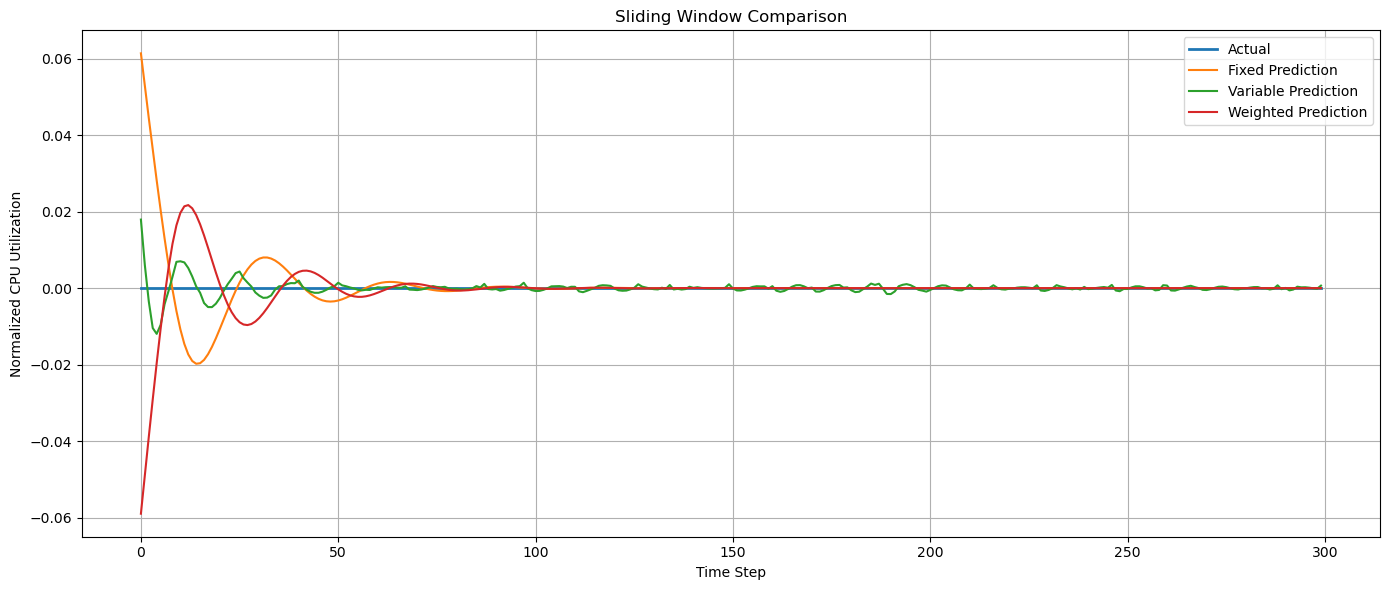

NameError: name 'script' is not defined

In [3]:
# Generates a Python script that:
# - Lets user set a single file path
# - Applies all 3 sliding window strategies to that file
# - Trains separate LSTM models per strategy
# - Plots one combined graph comparing the strategies

# ============================================================
# Sliding Window Strategy Comparison on One Selected File
# Applies Fixed, Variable, and Weighted windows
# Trains separate LSTM models
# Plots one combined graph with predictions vs actual
# ============================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# === 1. Set the file path manually ===
filepath = "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/Newest addition/Plateu/plateau_log.csv"  # <-- Change this!

# === 2. Sliding window strategies ===
def fixed_window(data, idx, size=20):
    if idx < size: return data[0:idx+1]
    return data[idx-size+1:idx+1]

def variable_window(data, idx, min_size=10, max_size=30):
    size = random.randint(min_size, max_size)
    if idx < size: return data[0:idx+1]
    return data[idx-size+1:idx+1]

def weighted_window(data, idx, size=20):
    if idx < size: window = data[0:idx+1]
    else: window = data[idx-size+1:idx+1]
    weights = np.linspace(0.1, 1.0, len(window)).reshape(-1, 1)
    return window * weights

strategy_map = {
    "Fixed": fixed_window,
    "Variable": variable_window,
    "Weighted": weighted_window
}

# === 3. Define LSTM model ===
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

# === 4. Training function ===
def train_strategy(data, strategy_fn, episodes=1):
    model = LSTMModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    predictions, actuals = [], []

    for ep in range(episodes):
        for t in range(30, len(data)-1):
            window = strategy_fn(data, t)
            x = torch.tensor(window, dtype=torch.float32)
            if x.ndim == 1:
                x = x.unsqueeze(0).unsqueeze(-1)  # [1, seq_len, 1]
            elif x.ndim == 2:
                x = x.unsqueeze(0)  # already shaped [seq_len, 1]

            y_true = torch.tensor(data[t+1], dtype=torch.float32).unsqueeze(0)

            y_pred = model(x)
            loss = loss_fn(y_pred, y_true)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predictions.append(y_pred.item())
            actuals.append(y_true.item())

    return predictions, actuals

# === 5. Main execution ===
if not os.path.exists(filepath):
    raise FileNotFoundError(f"File not found: {filepath}")

# Load and normalize data
df = pd.read_csv(filepath)
if 'Y' not in df.columns:
    raise ValueError("Dataset must contain a 'Y' column.")

scaler = MinMaxScaler()
normalized = scaler.fit_transform(df[['Y']].values).astype(np.float32)

# Run each strategy
results = {}
for strategy_name, strategy_fn in strategy_map.items():
    print(f"Running {strategy_name} window...")
    preds, actuals = train_strategy(normalized, strategy_fn)
    results[strategy_name] = preds

# Plot combined results
plt.figure(figsize=(14, 6))
plt.plot(actuals[:300], label='Actual', linewidth=2)
for strategy_name, preds in results.items():
    plt.plot(preds[:300], label=f"{strategy_name} Prediction")
plt.title("Sliding Window Comparison")
plt.xlabel("Time Step")
plt.ylabel("Normalized CPU Utilization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Save to file
single_file_script_path = "/Users/biraveennedunchelian/Documents/Masteroppgave/sliding_windows.py"
with open(single_file_script_path, "w") as f:
    f.write(script)

single_file_script_path
